## Context Tree selection using SMC

In [4]:
import sys
sys.path.insert(0,'../..')
cache_folder = 'resources/tmp/smc'
sample_file = 'resources/samples/model1_5000_s001.txt'
resamples_file = '%s/resamples.txt' % cache_folder

### 1. Create the sample object

In [5]:
from g4l.data import Sample

X = Sample(sample_file, [0, 1])
print('sample loaded:', X.data[0:40], '...')

sample loaded: 1001010100101010101010100101010010101001 ...


### 2. Instantiate the estimator

In [6]:
from g4l.estimators.smc import SMC

max_depth = 6
smc = SMC(max_depth, penalty_interval=(0, 500), epsilon=0.00001, cache_dir=cache_folder)
smc.fit(X)

# Retrieve the estimated champion trees
for i, tree in enumerate(smc.context_trees):
    print(i, '\t', tree.to_str())

Loaded from cache
0 	 000000 000010 000100 001000 001010 1 10000 100000 100010 10010 100100 10100 101000 101010
1 	 000000 000010 000100 001010 1 1000 10000 100000 100010 10010 100100 10100 101010
2 	 000000 000010 000100 1 1000 10000 100000 100010 10010 100100 1010 10100
3 	 000000 000010 1 100 1000 10000 100000 100010 10010 1010
4 	 000000 1 10 100 1000 10000 100000
5 	 000 1 10 100
6 	 00 1 10
7 	 0 1
8 	 


### 3. Find optimal tree using bootstrap

In [7]:
from g4l.bootstrap.resampling import BlockResampling

# 3.1 Generate the samples using one of the available factories 
sample_size = X.len()
resample_sizes = (sample_size * 0.3, sample_size * 0.9)
renewal_point = '1'

resample_factory = BlockResampling(X, resamples_file, resample_sizes, renewal_point)
resample_factory.generate(200, num_cores=4) # generates 200 resamples using 4 processors

In [8]:
from g4l.bootstrap import Bootstrap

# 3.2 Calculate likelihoods
bootstrap = Bootstrap(smc.context_trees, resamples_file, resample_sizes)
L = bootstrap.calculate_likelihoods(cache_folder, num_cores=4)
L.shape

Calculating likelihood j= 1


100%|██████████| 1800/1800 [02:17<00:00, 13.10it/s]


Calculating likelihood j= 2


100%|██████████| 1800/1800 [07:13<00:00,  4.16it/s]


(2, 9, 200)

In [9]:
# 3.3 Calculate diffs
diffs = bootstrap.calculate_diffs(L)

# 3.4 Find optimal tree using t-test
opt_idx = bootstrap.find_optimal_tree(diffs, alpha=0.01)
selected_tree = smc.context_trees[opt_idx]
print("Optimal tree found: ", opt_idx)
print("Selected tree: ", selected_tree)

Optimal tree found:  5
Selected tree:  000 1 10 100


### Visualizing change or regime:

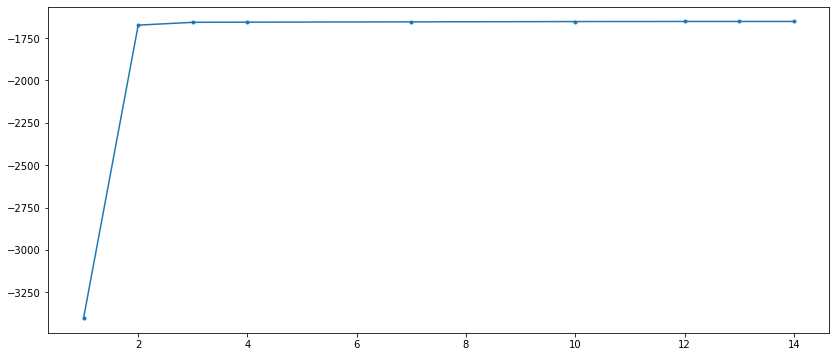

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
num_contexts = [t.num_contexts() for t in smc.context_trees]
likelihoods = [t.log_likelihood() for t in smc.context_trees]
plt.plot(num_contexts, likelihoods, marker='.')
plt.show()

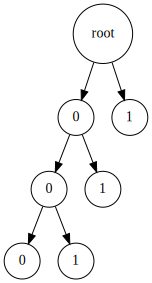

In [11]:
# A visual representation of the selected tree:
import g4l.display
g4l.display.draw_tree(selected_tree, size='200,400')